In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils import paths

# import the necessary packages for resnet, cnn, and dense net using cuda
from keras.applications import ResNet50
from keras.applications import DenseNet121
from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import MobileNetV2

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.models import load_model



# import packages to check and use gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



%matplotlib inline

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10014505779907220727
xla_global_id: -1
]


In [2]:
train = pd.read_csv(r'C:\Users\commo\OneDrive - University of Virginia\Work Documents\Coding Projects\Kaggle\Mammogram Prediction\train.csv\train.csv')

In [3]:
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [4]:
image_ids = train.sort_values(by = 'cancer', ascending = False).groupby('patient_id')['image_id'].apply(list)

cancer_labels = train.sort_values(by = 'cancer', ascending = False)['cancer'].values

In [5]:
path = r'C:\Users\commo\OneDrive - University of Virginia\Work Documents\Coding Projects\Kaggle\Mammogram Prediction\images_as_pngs_cv2_vl_256\train_images_processed_cv2_vl_256'

# Load the images into the dataframe
def load_images(image_ids, path):
    loaded_images = []
    images_loaded = 0
    for patient_id, image_idslist in image_ids.items():

        if images_loaded % 100 == 0:
            print('Loaded {} images'.format(images_loaded))
                                                
        for image_id in image_idslist:
            image = cv2.imread(path + '\\' + str(patient_id) + '\\' + str(image_id) + '.png')
            loaded_images.append(image)
            images_loaded += 1


    if len(loaded_images) == 0:
        print('No images found')
    else:
        print('Images loaded')

    return loaded_images

both_images = load_images(image_ids, path)

Loaded 0 images
Loaded 100 images
Loaded 900 images
Loaded 1400 images
Loaded 1500 images
Loaded 1600 images
Loaded 2100 images
Loaded 2200 images
Loaded 2900 images
Loaded 3000 images
Loaded 4000 images
Loaded 4500 images
Loaded 5100 images
Loaded 5200 images
Loaded 6700 images
Loaded 7600 images
Loaded 8500 images
Loaded 8700 images
Loaded 8800 images
Loaded 8900 images
Loaded 9300 images
Loaded 9400 images
Loaded 9700 images
Loaded 10200 images
Loaded 10600 images
Loaded 11300 images
Loaded 11500 images
Loaded 11600 images
Loaded 12100 images
Loaded 12200 images
Loaded 13000 images
Loaded 13100 images
Loaded 13300 images
Loaded 13600 images
Loaded 14600 images
Loaded 15200 images
Loaded 16300 images
Loaded 16700 images
Loaded 16900 images
Loaded 18400 images
Loaded 18500 images
Loaded 19800 images
Loaded 20000 images
Loaded 20100 images
Loaded 20200 images
Loaded 20600 images
Loaded 20700 images
Loaded 21200 images
Loaded 21400 images
Loaded 22600 images
Loaded 23200 images
Loaded 2

In [6]:
# Image pre-processing and augmentation

# Features I Want to Test: Segmentation, Color Scale, Better DeNoising, Higher Resolution, CLAHE vs Histogram Equalization
# Training on Larger Images/Datasets, Feature Engineering, Optimize Computation Time, and Other Convolutional Neural Networks

# Create a histogram equalization function for the images to improve contrast
def hist_equalization(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

# Create a CLAHE function for the images to improve contrast
def clahe(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image)
    # back to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

# Create a function to normalize the image

def normalize(image):
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return image

# Reduce the dimension to 1 channel to reduce computation time in grey scale

def grey_scale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# Create a function to apply a function to all images in a list
def apply_function_all(images, function):
    processed_images = []
    for image in images:
        processed_images.append(function(image))
    return processed_images

In [7]:
# plot a side by side comparison of the original and equalized images

def plot_side_by_side(images, titles):
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set(title=titles[i])
    plt.show()



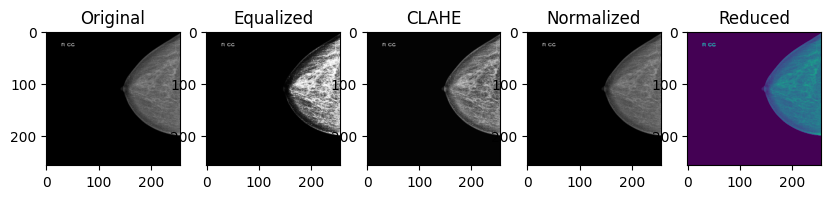

Shape of the original image: (256, 256, 3)
Shape of the equalized image: (256, 256, 3)
Shape of the CLAHE image: (256, 256, 3)
Shape of the normalized image: (256, 256, 3)
Shape of the grey scale image: (256, 256)


In [8]:
# Visualize the original and equalized images

plot_side_by_side([both_images[0], hist_equalization(both_images[0]), clahe(both_images[0]), normalize(both_images[0]),grey_scale(both_images[0])], ['Original', 'Equalized','CLAHE','Normalized','Reduced'])

# Printt the shape of the images

print('Shape of the original image: {}'.format(both_images[0].shape))

# Print the shape of the equalized images

print('Shape of the equalized image: {}'.format(hist_equalization(both_images[0]).shape))

# Print the shape of the CLAHE images

print('Shape of the CLAHE image: {}'.format(clahe(both_images[0]).shape))

# Print the shape of the normalized images

print('Shape of the normalized image: {}'.format(normalize(both_images[0]).shape))

# Print the shape of the grey scale images

print('Shape of the grey scale image: {}'.format(grey_scale(both_images[0]).shape))



Skipped for now because of memory issues

Equalize all of the images and resize them back to (256, 256)

both_images = apply_function_all(both_images, hist_equalization)

both_images = apply_function_all(both_images, normalize)

both_images = reshape_images(both_images)

(256, 256, 3)


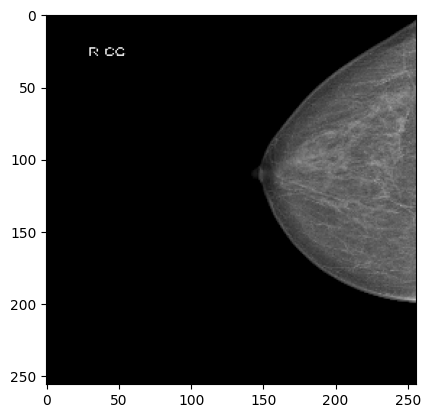

In [23]:
plt.imshow(both_images[0])

print(both_images[0].shape)

In [46]:
# Apply the functions to the images

def split_data(images, labels, test_size):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(both_images, cancer_labels, test_size=0.2)

In [49]:
# Reshape the data to be in the correct format for the model

y_train = y_train.reshape(-1, 1)

X_train = np.array(X_train)

y_test = y_test.reshape(-1, 1)

X_test = np.array(X_test)

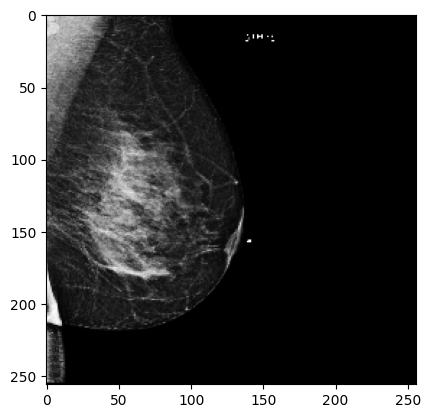

In [62]:
plt.imshow(X_train[5002])

In [50]:
# Create a 3-layer CNN model

def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [51]:
# Fit the model to the train 
cnn_modelx = cnn_model()

cnn_modelx.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data

cnn_model.evaluate(X_test, y_test)

# Predict the labels for the test data

y_pred = cnn_model.predict(X_test)

# Save the model

cnn_model.save('cnn_model.h5')


Epoch 1/2
1368/1368 [==============================] - 717s 523ms/step - loss: 0.1801 - accuracy: 0.9783 - val_loss: 0.1108 - val_accuracy: 0.9779
Epoch 2/2
1368/1368 [==============================] - 667s 487ms/step - loss: 0.1047 - accuracy: 0.9790 - val_loss: 0.1111 - val_accuracy: 0.9778


<AxesSubplot: >

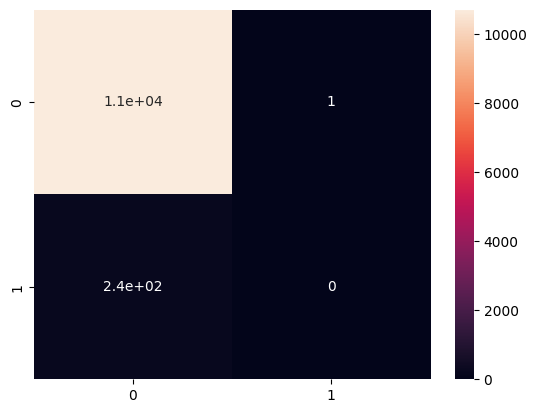

In [54]:
# Show the confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True)

In [57]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0
    
pfbeta(y_test, y_pred, 1)

array([0.0223476], dtype=float32)

In [63]:
image_ids = train.groupby('patient_id')['image_id'].apply(list)

In [68]:
import tensorflow as tf

cnn_models = tf.keras.models.load_model(r'C:\Users\commo\OneDrive - University of Virginia\Work Documents\Coding Projects\Kaggle\Mammogram Prediction\cnn_model.h5')

In [71]:
len(both_images)

54706

In [72]:
# Create a list of predictions to be in the cancer probability column
predictions = []

for image in both_images:
    # Predict the probability of cancer
    prediction = cnn_models.predict(np.array([image]))
    # Append the prediction to the list
    predictions.append(prediction[0][0])

# Group predictions by prediction_id and taking the mean of the predictions, take the mode of the age, implant, and machine_id
predictions = pd.DataFrame({'prediction_id': train['patient_id'], 'cancer_probability': predictions, 'age': train['age'], 'implant': train['implant'], 'machine_id': train['machine_id']})
predictions.head()
# Feed through a LightGBM model
# Submit

1/1 [==============================] - 0s 45ms/step


## Reasons for Failure

1. Class Imbalance

2. Bad Data Processing

3. Bad Network Model

4. Bad Prediction Model

5. Not Enough Data

## Self-Improvement

0x. Learn how to code with more efficiency

0. Learn how to process big files and directories

1. Create a quicker EDA process 
(Clustering, Disitrbutions, Missing Values, Categorical vs. Quantitative, Heatmaps, Interesting Visualizations)

2. Create a clever Feature Engineering process
(Categorical Encoding, Transforming Distributions, Normalizing, Standardizing, Reshaping, Formatting, Correlations)

3. Create a cleaner Training process
(Validation Method, Splitting Data, Visualizing Model Performance, Model Selection)

4. Create a submission process
(DataFrame Manipulation, Probability Selection, Candidate Generation, Merging Predictions)

5. Read Papers/Domain Knowledge to Understand Problem/Solution